In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pickle
import warnings
import os
warnings.filterwarnings("ignore")
pd.set_option('max_colwidth', 60)
from scipy import stats
from tqdm import tqdm, trange
from random import seed
from random import randrange
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
rawdatasplitwithoutmissingvalues= open('/content/drive/MyDrive/PrudentialData/rawdatasplitwithoutmissingvalues', 'rb')
# prudential_files= open(os.getcwd()+'/prudential_files', 'rb')
train,cv, test= pickle.load(rawdatasplitwithoutmissingvalues)
print(train.shape, cv.shape, test.shape)

(47504, 128) (11877, 128) (19765, 127)


In [3]:
prudential_files= open('/content/drive/MyDrive/PrudentialData/prudential_files', 'rb')
# prudential_files= open(os.getcwd()+'/prudential_files', 'rb')
train_final,cv_final, test_final= pickle.load(prudential_files)
print(train_final.shape, cv_final.shape, test_final.shape)

(47504, 119) (11877, 119) (19765, 118)


# Data Wrangling

## Handling Outlier

In [6]:
print("FLoating Features in train data: \n",train_final.columns[train_final.dtypes =='float64'].values)
#creating copies
train_final_Out_rm = train_final.copy()
cv_final_Out_rm = cv_final.copy()
test_final_Out_rm = test_final.copy()


def handle_outlier(variable, data):
  mean = np.mean(data[variable])
  sd = np.std(data[variable])
  # print(mean, sd)
  data[variable] = data[(data[variable]>(mean+3*sd)) | (data[variable]<(mean+3*sd))][variable] =0.0

  return data[variable]

train_final_Out_rm['Ins_Age'] = handle_outlier('Ins_Age', train_final_Out_rm)
train_final_Out_rm['Ht'] = handle_outlier('Ht', train_final_Out_rm)
train_final_Out_rm['Wt'] = handle_outlier('Wt', train_final_Out_rm)
train_final_Out_rm['BMI'] = handle_outlier('BMI', train_final_Out_rm)

cv_final_Out_rm['Ins_Age'] = handle_outlier('Ins_Age', cv_final_Out_rm)
cv_final_Out_rm['Ht'] = handle_outlier('Ht', cv_final_Out_rm)
cv_final_Out_rm['Wt'] = handle_outlier('Wt', cv_final_Out_rm)
cv_final_Out_rm['BMI'] = handle_outlier('BMI', cv_final_Out_rm)

test_final_Out_rm['Ins_Age'] = handle_outlier('Ins_Age', test_final_Out_rm)
test_final_Out_rm['Ht'] = handle_outlier('Ht', test_final_Out_rm)
test_final_Out_rm['Wt'] = handle_outlier('Wt', test_final_Out_rm)
test_final_Out_rm['BMI'] = handle_outlier('BMI', test_final_Out_rm)

FLoating Features in train data: 
 ['Product_Info_4' 'Ins_Age' 'Ht' 'Wt' 'BMI' 'Employment_Info_1'
 'Employment_Info_4' 'Employment_Info_6' 'Medical_History_1']


## Imputing Missing Values

Now we still have 4 columns left with missing data, we will be imputing value corresponding to missing values with some strategy in these columns in train data and same strategy will be used in test data. 

In [4]:
print((train_final.isnull().sum()*100/train_final.shape[0]).sort_values(ascending=False))
null_columns = dict((train_final.isnull().sum()*100/train_final.shape[0]).sort_values(ascending=False)).keys()
null_columns= list(null_columns)[:4]
null_columns

Employment_Info_6     18.238464
Medical_History_1     14.929269
Employment_Info_4     11.403250
Employment_Info_1      0.033681
Response               0.000000
                        ...    
Medical_Keyword_14     0.000000
Medical_Keyword_15     0.000000
Medical_Keyword_16     0.000000
Medical_Keyword_17     0.000000
Id                     0.000000
Length: 119, dtype: float64


['Employment_Info_6',
 'Medical_History_1',
 'Employment_Info_4',
 'Employment_Info_1']

['Employment_Info_6', 'Medical_History_1', 'Employment_Info_4', 'Employment_Info_1']


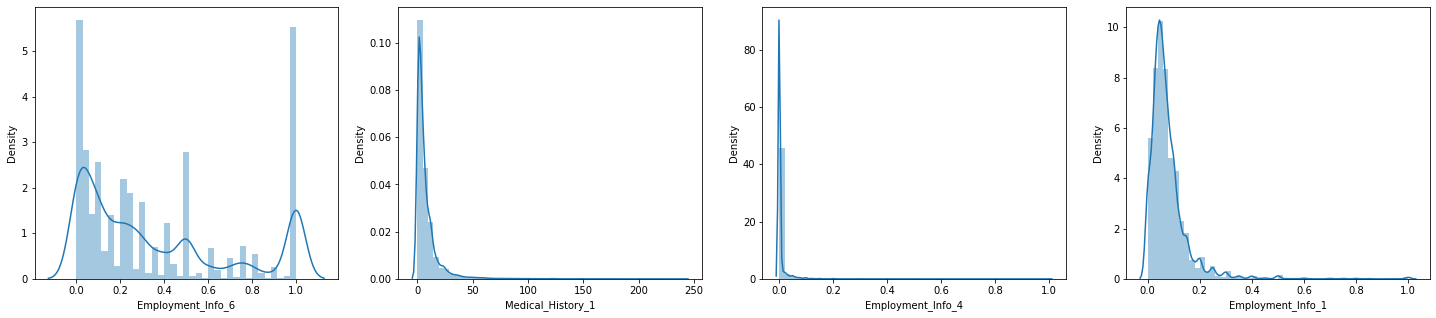

In [ ]:
#checking the distribution plots of null_coolumns left, so as to determine which imputation methods fit best
print(null_columns)
fig, axs = plt.subplots(1, 4, figsize=(25, 5))

sns.distplot(x=train_final[null_columns[0]],ax=axs[0], axlabel=null_columns[0])
sns.distplot(x=train_final[null_columns[1]],ax=axs[1],axlabel=null_columns[1])
sns.distplot(x=train_final[null_columns[2]],ax=axs[2], axlabel=null_columns[2])
sns.distplot(x=train_final[null_columns[3]],ax=axs[3],axlabel=null_columns[3])

plt.show()

For imputing missing values, we will impute the median value since the distributions are skewed for all missing values features in training data. The same imputation strategy we will follow for test data also. 


We will be using Simple imputer from sklearn library with imputing strategy as
 **median**. This function helps in easy imputation.

In [7]:
#creating copies of TRain_final and Train_final with outliers removed and imputing Median inplace of missing values
train_md= train_final.copy()
cv_md= cv_final.copy()
test_md= test_final.copy()

my_impute = SimpleImputer(strategy='median')
train_md[null_columns] = my_impute.fit_transform(train_md[null_columns])
cv_md[null_columns] = my_impute.transform(cv_md[null_columns])
test_md[null_columns] = my_impute.transform(test_md[null_columns])

print("Verifying the missing values in train data after imputing with median values: \n")
print(train_md.isnull().sum().sort_values(ascending=False))


#Data with outliers removed, creating copies of data and imputing median
train_out_md= train_final_Out_rm.copy()
cv_out_md= cv_final_Out_rm.copy()
test_out_md= test_final_Out_rm.copy()

my_impute = SimpleImputer(strategy='median')
train_out_md[null_columns] = my_impute.fit_transform(train_out_md[null_columns])
cv_out_md[null_columns] = my_impute.transform(cv_out_md[null_columns])
test_out_md[null_columns] = my_impute.transform(test_out_md[null_columns])

#Creating copies of data and imputing median for Baseline model prediction
train_x= train_final.copy()
cv_x= cv_final.copy()
test_x= test_final.copy()

my_impute = SimpleImputer(strategy='median')
train_x[null_columns] = my_impute.fit_transform(train_x[null_columns])
cv_x[null_columns] = my_impute.transform(cv_x[null_columns])
test_x[null_columns] = my_impute.transform(test_x[null_columns])

Verifying the missing values in train data after imputing with median values: 

Response               0
Medical_History_12     0
Insurance_History_9    0
Family_Hist_1          0
Medical_History_1      0
                      ..
Medical_Keyword_14     0
Medical_Keyword_15     0
Medical_Keyword_16     0
Medical_Keyword_17     0
Id                     0
Length: 119, dtype: int64



**Creating Datasets**
1.   For Baseline Model prediction (imputed median as missing value)
2.   Median imputation with Label Encoding
3.   Median Imputation with One Hot Encoding
4.   Median Imputation and Outliers Removed from Numerical features(Ht, Wt,
     Age, BMI with Label Encoding.
5.   Median Imputation and Outliers Removed from Numerical features(Ht, Wt,
     Age, BMI with One Hot Encoding.



## Feature Engineering

In [8]:
train_md.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_2,Employment_Info_3,Employment_Info_4,Employment_Info_5,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_6,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_3,Insurance_History_4,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,...,Medical_Keyword_10,Medical_Keyword_11,Medical_Keyword_12,Medical_Keyword_13,Medical_Keyword_14,Medical_Keyword_15,Medical_Keyword_16,Medical_Keyword_17,Medical_Keyword_18,Medical_Keyword_19,Medical_Keyword_20,Medical_Keyword_21,Medical_Keyword_22,Medical_Keyword_23,Medical_Keyword_24,Medical_Keyword_25,Medical_Keyword_26,Medical_Keyword_27,Medical_Keyword_28,Medical_Keyword_29,Medical_Keyword_30,Medical_Keyword_31,Medical_Keyword_32,Medical_Keyword_33,Medical_Keyword_34,Medical_Keyword_35,Medical_Keyword_36,Medical_Keyword_37,Medical_Keyword_38,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48,Response
38963,51725,1,D2,26,0.384615,2,3,1,0.552239,0.781818,0.322176,0.446623,0.100,9,1,0.00,2,0.35,1,2,11,3,1,1,1,1,1,3,1,1,1,2,3,1.0,171,2,1,1,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8
38922,51668,1,D4,26,1.000000,2,3,1,0.164179,0.890909,0.539749,0.637699,0.060,14,1,0.00,2,0.15,1,2,4,3,1,1,1,2,1,1,3,3,2,3,3,8.0,260,2,1,1,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5
15466,20614,1,E1,26,0.128205,2,3,1,0.462687,0.618182,0.251046,0.496592,0.000,1,3,0.04,2,0.50,1,2,3,3,1,2,1,2,1,3,1,1,3,1,3,1.0,613,3,2,1,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,2
38282,50821,1,B2,26,0.230769,2,3,1,0.447761,0.563636,0.225941,0.510720,0.025,9,1,0.00,2,0.00,1,2,6,3,1,2,3,2,1,3,2,1,3,2,3,9.0,491,2,2,1,3,2,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6
36843,48931,1,D1,10,0.230769,2,3,1,0.507463,0.654545,0.309623,0.565608,0.000,1,3,0.00,3,0.25,1,2,8,3,1,2,1,2,1,1,3,3,2,3,3,1.0,276,2,1,1,3,2,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6


In [9]:
def categorize(data, variable, categories):
  first = np.quantile(data[variable], 0.25)
  second = np.quantile(data[variable], 0.75)
  category =[]
  for i in range(data[variable].shape[0]):
    if data[variable].values[i]<first:
      category.append(categories[0])
    elif (data[variable].values[i]>=first) and  (data[variable].values[i]<second):
      category.append(categories[1])
    else:
      category.append(categories[2])
  return list(category)

In [11]:
#categorizing Height, Weight, BMI and Ins_Age

def feature_gen(train_data, cv_data, test_data):
  
  train_data['Height_cat'] = categorize(train_data, 'Ht', ['short','average','tall'])
  train_data['BMI_cat'] = categorize(train_data, 'BMI', ['low','normal','high'])
  train_data['Ins_Age_cat'] = categorize(train_data, 'Ins_Age', ['underweight','average','overweight'])
  train_data['Wt_cat'] = categorize(train_data, 'Wt',['young','average','old'])

  cv_data['Height_cat'] = categorize(cv_data, 'Ht', ['short','average','tall'])
  cv_data['BMI_cat'] = categorize(cv_data, 'BMI', ['low','normal','high'])
  cv_data['Ins_Age_cat'] = categorize(cv_data, 'Ins_Age', ['underweight','average','overweight'])
  cv_data['Wt_cat'] = categorize(cv_data, 'Wt',['young','average','old'])

  test_data['Height_cat'] = categorize(test_data, 'Ht', ['short','average','tall'])
  test_data['BMI_cat'] = categorize(test_data, 'BMI', ['low','normal','high'])
  test_data['Ins_Age_cat'] = categorize(test_data, 'Ins_Age', ['underweight','average','overweight'])
  test_data['Wt_cat'] = categorize(test_data, 'Wt',['young','average','old'])

  #******************************************************************
  # deleting all Medical Keywords and replacing with the sum of them
  medical_keyword =   [i for i in train_data.columns if 'Medical_Keyword' in str(i)]
  train_data['Medical_Keyword'] = train_data[medical_keyword].sum(axis=1)

  #dropping all medical keyword columns
  train_data = train_data.drop(medical_keyword, axis=1)

  medical_keyword =   [i for i in cv_data.columns if 'Medical_Keyword' in str(i)]
  cv_data['Medical_Keyword'] = cv_data[medical_keyword].sum(axis=1)

  #dropping all medical keyword columns
  cv_data = cv_data.drop(medical_keyword, axis=1)

  medical_keyword =   [i for i in test_data.columns if 'Medical_Keyword' in str(i)]
  test_data['Medical_Keyword'] = test_data[medical_keyword].sum(axis=1)

  test_data = test_data.drop(medical_keyword, axis=1)

  #******************************************************************
  #Adding BMI*Age , Ht*Age, Wt*Age
  #BMI*AGE
  train_data['BMI_AGE'] = (train_data['BMI']*train_data['Ins_Age'])
  cv_data['BMI_AGE'] = (cv_data['BMI']*cv_data['Ins_Age'])
  test_data['BMI_AGE'] = (test_data['BMI']*test_data['Ins_Age'])

  #Wt *Age
  train_data['Wt_AGE'] = (train_data['Wt']*train_data['Ins_Age'])
  cv_data['Wt_AGE'] = (cv_data['Wt']*cv_data['Ins_Age'])
  test_data['Wt_AGE'] = (test_data['Wt']*test_data['Ins_Age'])

  #Ht *Age
  train_data['Ht_AGE'] = (train_data['Ht']*train_data['Ins_Age'])
  cv_data['Ht_AGE'] = (cv_data['Ht']*cv_data['Ins_Age'])
  test_data['Ht_AGE'] = (test_data['Ht']*test_data['Ins_Age'])
  #***************************************************************

  # defining new category i.e. high Risk and Low risk
  # High Risk = Overweight or Underweight or High or Low or Old
  #Weights:   0- Average        1-OverWeight     2-underweight    
  #heights    0-Average         1-Short          2-Tall       
  #Age        0-AVERAGE         1-OLD            2-YOUNG      
  #BMI        0-HIGH            1-LOW            2-NORMAL    

  #High Risk Category  1-high risk ,  0 not high risk

  ### Training Data
  train_data['high_risk']=np.zeros(train_data.shape[0])
  indices =train_data[(train_data['Wt_cat']=='OverWeight') | (train_data['BMI_cat']=='HIGH')|
                        (train_data['BMI_cat']=='LOW') | (train_data['Ins_Age_cat']=='OLD') | 
                        (train_data['Wt_cat']=='underweight')].index
  train_data.loc[indices,'high_risk']=1.0

  print("High Risk Feature Counts in train set: \n",train_data['high_risk'].value_counts(),"\n")

  ### CV Data
  cv_data['high_risk']=np.zeros(cv_data.shape[0])
  indices =cv_data[(cv_data['Wt_cat']=='OverWeight') | (cv_data['BMI_cat']=='HIGH')|
                        (cv_data['BMI_cat']=='LOW') | (cv_data['Ins_Age_cat']=='OLD') | 
                        (cv_data['Wt_cat']=='underweight')]['Id'].index
  cv_data.loc[indices,'high_risk']=1.0

  print("High Risk Feature Counts in cv set: \n",cv_data['high_risk'].value_counts(),"\n")

  ### Testing Data
  test_data['high_risk']=np.zeros(test_data.shape[0])
  indices =test_data[(test_data['Wt_cat']=='OverWeight') | (test_data['BMI_cat']=='HIGH')|
                        (test_data['BMI_cat']=='LOW') | (test_data['Ins_Age_cat']=='OLD') | 
                        (test_data['Wt_cat']=='underweight')]['Id'].index

  test_data.loc[indices,'high_risk']=1.0
  print("\nHigh Risk Feature Counts in test set: \n",test_data['high_risk'].value_counts(),"\n")

  #******************************************************************
  #drop Product_Info_3 and Employment_Info_5, replace them with their Product 
  # (Since Product of these features tend to lower the correlation between these variables)
  train_data['Prod_Info_3_Emp_Info_5'] = train_data['Employment_Info_5']*train_data['Product_Info_3']
  train_data=train_data.drop(['Employment_Info_5', 'Product_Info_3'],axis=1)

  cv_data['Prod_Info_3_Emp_Info_5'] = cv_data['Employment_Info_5']*cv_data['Product_Info_3']
  cv_data=cv_data.drop(['Employment_Info_5', 'Product_Info_3'],axis=1)

  test_data['Prod_Info_3_Emp_Info_5'] = test_data['Employment_Info_5']*test_data['Product_Info_3']
  test_data=test_data.drop(['Employment_Info_5', 'Product_Info_3'],axis=1)

  #*******************************************************************
  #Dropping highly correlated Variables, since their correlation is closer to perfect negative.
  #Drop Insurance_Hist_3

  train_data=train_data.drop('Insurance_History_3',axis=1)
  cv_data=cv_data.drop('Insurance_History_3',axis=1)
  test_data=test_data.drop('Insurance_History_3',axis=1)


  #*******************************************************************
  #Employment_Info_3 category 3 occurs only when Employment_info_2's category 1 is selected hence making a 
  # separate feature of their co-occurence and dropping the original
  # 1- (Employment_Info_3 ==3 and Employment_Info_2==1) and 0 Otherwise

  train_data['Employment_Info2_3_cooccur']= np.zeros(train_data.shape[0])
  indices = train_data[(train_data['Employment_Info_2']==1) & (train_data['Employment_Info_3']==3)]['Employment_Info2_3_cooccur'].index
  train_data.loc[indices,'Employment_Info2_3_cooccur']=1
  train_data= train_data.drop(['Employment_Info_2','Employment_Info_3'], axis=1)

  cv_data['Employment_Info2_3_cooccur']= np.zeros(cv_data.shape[0])
  indices = cv_data[(cv_data['Employment_Info_2']==1) & (cv_data['Employment_Info_3']==3)]['Employment_Info2_3_cooccur'].index
  cv_data.loc[indices,'Employment_Info2_3_cooccur']=1
  cv_data= cv_data.drop(['Employment_Info_2','Employment_Info_3'], axis=1)

  test_data['Employment_Info2_3_cooccur']= np.zeros(test_data.shape[0])
  indices = test_data[(test_data['Employment_Info_2']==1) & (test_data['Employment_Info_3']==3)]['Employment_Info2_3_cooccur'].index
  test_data.loc[indices,'Employment_Info2_3_cooccur']=1
  test_data= test_data.drop(['Employment_Info_2','Employment_Info_3'], axis=1)


  # *********************************************************************
  #Dropping InsuredInfo_6 and Ht feature and adding Ht/InsuredInfo_6 as new feature

  train_data['Ht/InsuredInfo_6']= train_data['Ht']/train_data['InsuredInfo_6']
  train_data = train_data.drop(['Ht','InsuredInfo_6'],axis=1)

  cv_data['Ht/InsuredInfo_6']= cv_data['Ht']/cv_data['InsuredInfo_6']
  cv_data = cv_data.drop(['Ht','InsuredInfo_6'],axis=1)

  test_data['Ht/InsuredInfo_6']= test_data['Ht']/test_data['InsuredInfo_6']
  test_data = test_data.drop(['Ht','InsuredInfo_6'],axis=1)

  #**************************************************************************
  #splitting the Char and Number from the Product_Info2 feature
  train_data['Product_Info_2_char'] = [i[0] for i in train_data['Product_Info_2']]
  train_data['Product_Info_2_no'] = [int(i[1]) for i in train_data['Product_Info_2']]

  cv_data['Product_Info_2_char'] = [i[0] for i in cv_data['Product_Info_2']]
  cv_data['Product_Info_2_no'] = [int(i[1]) for i in cv_data['Product_Info_2']]

  test_data['Product_Info_2_char'] = [i[0] for i in test_data['Product_Info_2']]
  test_data['Product_Info_2_no'] = [int(i[1]) for i in test_data['Product_Info_2']]
  return train_data, cv_data, test_data

# train, cv, test = feature_gen(train, cv, test)  
train_md, cv_md, test_md = feature_gen(train_md, cv_md, test_md)
train_out_md, cv_out_md, test_out_md = feature_gen(train_out_md, cv_out_md, test_out_md)
print(train_md.shape,cv_md.shape, test_md.shape)
print(train_out_md.shape, cv_out_md.shape, test_out_md.shape)
# we will add features for without outlier dataset later as per requirement

High Risk Feature Counts in train set: 
 0.0    47504
Name: high_risk, dtype: int64 

High Risk Feature Counts in cv set: 
 0.0    11877
Name: high_risk, dtype: int64 


High Risk Feature Counts in test set: 
 0.0    19765
Name: high_risk, dtype: int64 

High Risk Feature Counts in train set: 
 0.0    47504
Name: high_risk, dtype: int64 

High Risk Feature Counts in cv set: 
 0.0    11877
Name: high_risk, dtype: int64 


High Risk Feature Counts in test set: 
 0.0    19765
Name: high_risk, dtype: int64 

(47504, 78) (11877, 78) (19765, 77)
(47504, 78) (11877, 78) (19765, 77)


In [ ]:
##Splitting data into x's anf Y's

#1 For Baseline Model prediction (imputed median as missing value)

train_xi = train_x.drop(['Id','Response'],axis=1)
train_yi = train_x['Response']
cv_xi = cv_x.drop(['Id','Response'],axis=1)
cv_yi = cv_x['Response']
test_xi = test_x.drop(['Id'],axis=1)


#2 Median imputation with Label Encoding
x_train_md_le = train_md.drop(['Id','Response'],axis=1)
x_cv_md_le = cv_md.drop(['Id','Response'],axis=1)
x_test_md_le = test_md.drop(['Id'],axis=1)
y_train_md_le = train_md['Response']
y_cv_md_le = cv_md['Response']

#3 Median imputation with One Hot Encoding
x_train_md_ohe = train_md.drop(['Id','Response'],axis=1)
x_cv_md_ohe = cv_md.drop(['Id','Response'],axis=1)
x_test_md_ohe = test_md.drop(['Id'],axis=1)
y_train_md_ohe = train_md['Response']
y_cv_md_ohe = cv_md['Response']

#4 Median Imputation and Outliers Removed from Numerical features(Ht, Wt, Age, BMI with Label Encoding.
x_train_out_md_le = train_out_md.drop(['Id','Response'],axis=1)
x_cv_out_md_le = cv_out_md.drop(['Id','Response'],axis=1)
x_test_out_md_le = test_out_md.drop(['Id'],axis=1)
y_train_out_md_le = train_out_md['Response']
y_cv_out_md_le = cv_out_md['Response']

#5 Median Imputation and Outliers Removed from Numerical features(Ht, Wt, Age, BMI with One Hot Encoding.
x_train_out_md_ohe = train_out_md.drop(['Id','Response'],axis=1)
x_cv_out_md_ohe = cv_out_md.drop(['Id','Response'],axis=1)
x_test_out_md_ohe = test_out_md.drop(['Id'],axis=1)
y_train_out_md_ohe = train_out_md['Response']
y_cv_out_md_ohe = cv_out_md['Response']

#6 Median Imputation only, No SMOTE
X_train_md_ohe = train_md.drop(['Id','Response'],axis=1)
X_cv_md_ohe = cv_md.drop(['Id','Response'],axis=1)
X_test_md_ohe = test_md.drop(['Id'],axis=1)
Y_train_md_ohe = train_md['Response']
Y_cv_md_ohe = cv_md['Response']



In [ ]:
print(x_train_md_le.shape,x_cv_md_le.shape, x_test_md_le.shape)
print(x_train_out_md_le.shape, x_cv_out_md_le.shape, x_test_out_md_le.shape)

(47504, 76) (11877, 76) (19765, 76)
(47504, 76) (11877, 76) (19765, 76)


In [ ]:
# Encoding features using label encoding
def encoder(variable, train_data, cv_data, test_data):
  encoder =LabelEncoder()
  train_data_variable = encoder.fit_transform(train_data[variable])
  cv_data_variable = encoder.transform(cv_data[variable])
  test_data_variable = encoder.transform(test_data[variable])
  return train_data_variable, cv_data_variable, test_data_variable

#One Hot encoder 

def ohe(variable, train_data, cv_data, test_data):
  ohe =CountVectorizer()
  variable1= ohe.fit_transform(train_data[variable])
  variable2 = ohe.transform(cv_data[variable])
  variable3 = ohe.transform(test_data[variable])
  return variable1, variable2, variable3

In [ ]:
x_train_md_le['BMI_cat']= x_train_md_le['BMI_cat'].astype('str')
x_cv_md_le['BMI_cat']= x_cv_md_le['BMI_cat'].astype('str')
x_test_md_le['BMI_cat']= x_test_md_le['BMI_cat'].astype('str')
train['BMI_cat']= train['BMI_cat'].astype('str')
cv['BMI_cat']= cv['BMI_cat'].astype('str')
test['BMI_cat']= test['BMI_cat'].astype('str')


In [ ]:
x_train_md_le['Height_cat'] =x_train_md_le['Height_cat'].astype('str') 
x_cv_md_le['Height_cat'] =x_cv_md_le['Height_cat'].astype('str')
x_test_md_le['Height_cat'] =x_test_md_le['Height_cat'].astype('str')

train['Height_cat'] =train['Height_cat'].astype('str') 
cv['Height_cat'] =cv['Height_cat'].astype('str')
test['Height_cat'] = test['Height_cat'].astype('str')


print(x_cv_md_le['Height_cat'].value_counts())

In [ ]:
print("Shapes before encoding :", x_train_md_le.shape, x_cv_md_le.shape, x_test_md_le.shape)
print("Shapes before encoding :", x_train_md_ohe.shape, x_cv_md_ohe.shape, x_test_md_ohe.shape)

Shapes before encoding : (47504, 76) (11877, 76) (19765, 76)
Shapes before encoding : (47504, 76) (11877, 76) (19765, 76)


In [ ]:
cat_cols = train.columns[train_md.dtypes=='object']

#Label Encoding

# train_xi['Product_Info_2'] = LabelEncoder().fit_transform(train_xi['Product_Info_2'])

print("\nEncoding Categorical columns in both train and test sets:", list(cat_cols))

for i in cat_cols:
  x_train_md_le[i], x_cv_md_le[i], x_test_md_le[i] = encoder(str(i), x_train_md_le, x_cv_md_le, x_test_md_le)
  x_train_out_md_le[i], x_cv_out_md_le[i], x_test_out_md_le[i] = encoder(i,x_train_out_md_le, x_cv_out_md_le, x_test_out_md_le)
  # X_train_md_le[i], X_cv_md_le[i], X_test_md_le[i] = encoder(i, X_train_md_le, X_cv_md_le, X_test_md_le)
#One Hot Encoding

def ohe_encode(train_data, cv_data, test_data):
    
    Product_Info_2, Product_Info_2_cv, Product_Info_2_test = ohe(cat_cols[0], train_data, cv_data, test_data)
    Height_cat, Height_cat_cv, Height_cat_test  = ohe(cat_cols[1], train_data, cv_data, test_data)
    BMI_cat, BMI_cat_cv, BMI_cat_test = ohe(cat_cols[2], train_data, cv_data, test_data)
    Ins_Age_cat, Ins_Age_cat_cv, Ins_Age_test = ohe(cat_cols[3], train_data, cv_data, test_data)
    Wt_cat, Wt_cat_cv, Wt_cat_test = ohe(cat_cols[4], train_data, cv_data, test_data)
    
    vector = CountVectorizer(vocabulary=np.unique(train_data['Product_Info_2_char'])).fit(train_data)
    Product_Info_2_char = vector.transform(train_data['Product_Info_2_char'])
    Product_Info_2_char_cv = vector.transform(cv_data['Product_Info_2_char'])
    Product_Info_2_char_test = vector.transform(test_data['Product_Info_2_char'])

    train_data = train_data.drop(cat_cols, axis=1)
    train_data = np.hstack((train_data, Product_Info_2.toarray(),Height_cat.toarray(), BMI_cat.toarray() , Ins_Age_cat.toarray() ,
                            Wt_cat.toarray(), Product_Info_2.toarray()))

    cv_data = cv_data.drop(cat_cols, axis=1)
    cv_data= np.hstack((cv_data, Product_Info_2_cv.toarray(),Height_cat_cv.toarray(), BMI_cat_cv.toarray() , Ins_Age_cat_cv.toarray() ,
                            Wt_cat_cv.toarray(), Product_Info_2_cv.toarray()))

    test_data = test_data.drop(cat_cols, axis=1)
    test_data= np.hstack((test_data, Product_Info_2_test.toarray(),Height_cat_test.toarray(), BMI_cat_test.toarray() , Ins_Age_test.toarray() ,
                            Wt_cat_test.toarray(),Product_Info_2_test.toarray()))
    return train_data, cv_data, test_data

x_train_md_ohe, x_cv_md_ohe, x_test_md_ohe = ohe_encode(x_train_md_ohe, x_cv_md_ohe, x_test_md_ohe)
x_train_out_md_ohe, x_cv_out_md_ohe, x_test_out_md_ohe = ohe_encode(x_train_out_md_ohe, x_cv_out_md_ohe, x_test_out_md_ohe)
X_train_md_ohe, X_cv_md_ohe, X_test_md_ohe = ohe_encode(X_train_md_ohe, X_cv_md_ohe, X_test_md_ohe)




Encoding Categorical columns in both train and test sets: ['Product_Info_2', 'Height_cat', 'BMI_cat', 'Ins_Age_cat', 'Wt_cat', 'Product_Info_2_char']


In [ ]:
print("Shapes after lable Encoding :", x_train_md_le.shape, x_cv_md_le.shape, x_test_md_le.shape)
print("Shapes after lable Encoding :", x_train_out_md_le.shape, x_cv_out_md_le.shape, x_test_out_md_le.shape)
print("\nAfter One Hot Encoding train, cv and test sets shape :",x_train_md_ohe.shape,x_cv_md_ohe.shape, x_test_md_ohe.shape,"\n")

Shapes after lable Encoding : (47504, 76) (11877, 76) (19765, 76)
Shapes after lable Encoding : (47504, 76) (11877, 76) (19765, 76)

After One Hot Encoding train, cv and test sets shape : (47504, 120) (11877, 120) (19765, 120) 



## Balancing Response Variable using SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
train_xi,train_yi =  oversample.fit_resample(train_xi,train_yi)
x_train_md_le,y_train_md_le =  oversample.fit_resample(x_train_md_le, y_train_md_le)
x_cv_md_le,y_cv_md_le =  oversample.fit_resample(x_cv_md_le, y_cv_md_le)
x_train_md_ohe, y_train_md_ohe = oversample.fit_resample(x_train_md_ohe, y_train_md_ohe)
x_cv_md_ohe, y_cv_md_ohe = oversample.fit_resample(x_cv_md_ohe, y_cv_md_ohe)
x_train_out_md_le, y_train_out_md_le = oversample.fit_resample(x_train_out_md_le, y_train_out_md_le)
x_cv_out_md_le, y_cv_out_md_le = oversample.fit_resample(x_cv_out_md_le, y_cv_out_md_le)
x_train_out_md_ohe, y_train_out_md_ohe = oversample.fit_resample(x_train_out_md_ohe, y_train_out_md_ohe)
x_cv_out_md_ohe, y_cv_out_md_ohe = oversample.fit_resample(x_cv_out_md_ohe, y_cv_out_md_ohe)

In [ ]:
### Dataset without SMOTE

print(Y_train_md_ohe.value_counts())

8    15591
6     8986
7     6421
2     5242
1     4966
5     4346
4     1142
3      810
Name: Response, dtype: int64


In [ ]:
# #Dataset_1

# file_baseline= open('/content/drive/MyDrive/PrudentialData/files_baseline', 'wb')
# pickle.dump((train_xi,cv_xi, test_xi, train_yi, cv_yi),file_baseline)
# file_baseline= open('/content/drive/MyDrive/PrudentialData/files_baseline', 'rb')
# train_xi,cv_xi, test_xi, train_yi, cv_yi= pickle.load(file_baseline)

#Dataset_2
 
# # file_median_impute = open('/content/drive/MyDrive/PrudentialData/file_median_impute', 'wb')
# # pickle.dump((x_train_md_le, x_cv_md_le, x_test_md_le, y_train_md_le,y_cv_md_le, x_train_md_ohe, x_cv_md_ohe, x_test_md_ohe, y_train_md_ohe,y_cv_md_ohe),file_median_impute)
# file_median_impute = open('/content/drive/MyDrive/PrudentialData/file_median_impute', 'rb')
# x_train_md_le, x_cv_md_le, x_test_md_le, y_train_md_le,y_cv_md_le, x_train_md_ohe, x_cv_md_ohe, x_test_md_ohe, y_train_md_ohe,y_cv_md_ohe= pickle.load(file_median_impute)

# #Dataset_3
 
# # file_median_impute_withOut = open('/content/drive/MyDrive/PrudentialData/file_median_impute_withOut', 'wb')
# # pickle.dump((x_train_out_md_le, x_cv_out_md_le, x_test_out_md_le, y_train_out_md_le, y_cv_out_md_le, x_train_out_md_ohe, x_cv_out_md_ohe, x_test_out_md_ohe, y_train_out_md_ohe,y_cv_out_md_ohe),file_median_impute_withOut)
# file_median_impute_withOut = open('/content/drive/MyDrive/PrudentialData/file_median_impute_withOut', 'rb')
# x_train_out_md_le, x_cv_out_md_le, x_test_out_md_le, y_train_out_md_le, y_cv_out_md_le, x_train_out_md_ohe, x_cv_out_md_ohe, x_test_out_md_ohe, y_train_out_md_ohe,y_cv_out_md_ohe= pickle.load(file_median_impute_withOut)


# #Dataset_4
# file_median_impute_withoutSMOTE = open('/content/drive/MyDrive/PrudentialData/file_median_impute_withoutSMOTE', 'wb')
# pickle.dump((X_train_md_ohe,X_cv_md_ohe, X_test_md_ohe, Y_train_md_ohe, Y_cv_md_ohe),file_median_impute_withoutSMOTE)
# file_median_impute_withoutSMOTE = open('/content/drive/MyDrive/PrudentialData/file_median_impute_withoutSMOTE', 'rb')
# X_train_md_ohe,X_cv_md_ohe, X_test_md_ohe, Y_train_md_ohe, Y_cv_md_ohe = pickle.load(file_median_impute_withoutSMOTE)

# #DataSet_5
# # file_medianImp_and_FE = open('/content/drive/MyDrive/PrudentialData/file_medianImp_and_FE', 'wb')
# # pickle.dump((train_md, cv_md, test_md),file_medianImp_and_FE)
# file_medianImp_and_FE = open('/content/drive/MyDrive/PrudentialData/file_medianImp_and_FE', 'rb')
# train_md, cv_md, test_md = pickle.load(file_medianImp_and_FE)

# FE train, test, cv with ṃissing values replaaced with -1

RawDataFE = open('/content/drive/MyDrive/PrudentialData/RawDataFE', 'wb')
pickle.dump((train, cv, test),RawDataFE)
RawDataFE = open('/content/drive/MyDrive/PrudentialData/RawDataFE', 'rb')
train, cv, test = pickle.load(RawDataFE)


In [ ]:
train.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Wt,BMI,Employment_Info_1,Employment_Info_4,Employment_Info_6,InsuredInfo_1,InsuredInfo_2,InsuredInfo_3,InsuredInfo_4,InsuredInfo_5,InsuredInfo_7,Insurance_History_1,Insurance_History_2,Insurance_History_4,Insurance_History_5,Insurance_History_7,Insurance_History_8,Insurance_History_9,Family_Hist_1,Family_Hist_2,Family_Hist_3,Family_Hist_4,Family_Hist_5,Medical_History_1,Medical_History_2,Medical_History_3,Medical_History_4,Medical_History_5,Medical_History_6,Medical_History_7,Medical_History_8,Medical_History_9,...,Medical_History_17,Medical_History_18,Medical_History_19,Medical_History_20,Medical_History_21,Medical_History_22,Medical_History_23,Medical_History_24,Medical_History_25,Medical_History_26,Medical_History_27,Medical_History_28,Medical_History_29,Medical_History_30,Medical_History_31,Medical_History_32,Medical_History_33,Medical_History_34,Medical_History_35,Medical_History_36,Medical_History_37,Medical_History_38,Medical_History_39,Medical_History_40,Medical_History_41,Response,Height_cat,BMI_cat,Ins_Age_cat,Wt_cat,Medical_Keyword,BMI_AGE,Wt_AGE,Ht_AGE,high_risk,Prod_Info_3_Emp_Info_5,Employment_Info2_3_cooccur,Ht/InsuredInfo_6,Product_Info_2_char,Product_Info_2_no
38963,51725,1,15,0.384615,2,3,1,0.552239,0.322176,0.446623,0.100,0.00,0.35,1,2,11,3,1,1,1,1,1,0.003000,1,1,2,3,0.608696,-1.000000,0.507042,-1.000000,1.0,171,2,1,1,3,2,2,1,...,3,1,1,2,2,2,3,-1.0,1,3,3,1,1,2,3,-1.0,3,3,1,2,2,1,3,3,3,8,2,2,0,0,2,0.246642,0.177918,0.431750,0.0,52,0.0,0.781818,3,2
38922,51668,1,17,1.000000,2,3,1,0.164179,0.539749,0.637699,0.060,-1.00,0.15,1,2,4,3,1,1,2,1,3,-1.000000,3,2,3,3,0.420290,-1.000000,0.338028,-1.000000,8.0,260,2,1,1,3,2,2,2,...,3,1,1,2,1,2,3,-1.0,1,3,3,1,3,2,3,-1.0,3,3,1,2,2,1,3,3,1,5,2,0,2,1,0,0.104697,0.088615,0.146269,0.0,52,0.0,0.890909,3,4
15466,20614,1,18,0.128205,2,3,1,0.462687,0.251046,0.496592,0.000,0.04,0.50,1,2,3,3,1,1,2,1,1,0.000419,1,3,1,3,-1.000000,0.617647,0.591549,-1.000000,1.0,613,3,2,1,3,2,2,2,...,3,1,2,2,1,2,3,-1.0,1,3,3,1,1,2,3,-1.0,3,3,1,2,2,1,3,3,3,2,1,2,0,0,5,0.229767,0.116156,0.286024,0.0,52,1.0,0.309091,4,1
38282,50821,1,9,0.230769,2,3,1,0.447761,0.225941,0.510720,0.025,0.00,0.00,1,2,6,3,1,3,2,1,2,0.000100,1,3,2,3,-1.000000,0.500000,0.478873,-1.000000,9.0,491,2,2,1,3,2,2,2,...,3,1,1,2,1,2,1,-1.0,1,3,3,1,3,2,3,-1.0,3,3,1,2,2,1,3,3,1,6,1,2,0,0,1,0.228680,0.101168,0.252374,0.0,52,0.0,0.281818,1,2
36843,48931,1,14,0.230769,2,3,1,0.507463,0.309623,0.565608,0.000,0.00,-1.00,1,2,8,3,1,1,2,1,3,-1.000000,3,2,3,3,-1.000000,0.529412,-1.000000,0.419643,1.0,276,2,1,1,3,2,2,2,...,3,1,1,2,1,2,3,-1.0,1,3,3,1,1,2,3,-1.0,1,3,1,2,2,1,3,3,1,6,0,0,0,0,4,0.287025,0.157122,0.332157,0.0,30,1.0,0.327273,3,1


In [ ]:
print(x_train_md_le.shape, x_cv_md_le.shape, x_test_md_le.shape)

(124728, 76) (31184, 76) (19765, 76)
